Mean amplitude of ST: 1.2360511302754953
Mean period of ST: 22.430909090909093


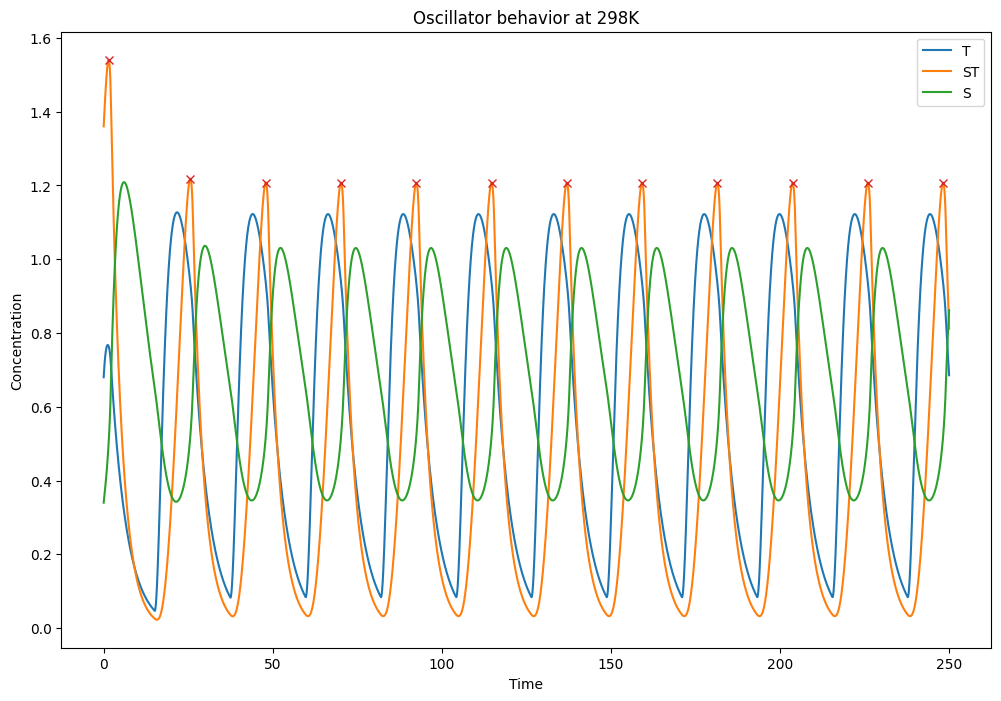